# Starbucks App Reward Program

This file only contains 3) Data Preparation, 4) Model Building and Validation, 5) Saving the Model and 6) Conclusion

**Authors: Joel Ligma**            
<br>
**Date: July 2020**


**Context**
<br>

The goal of this project was to *predict customer responsiveness* to specific marketing efforts. One of the main challenges of this project was to generate a single dataset derived from 3 datasets and to prepare the data for later analysis. The data files used for this project were sourced from Kaggle:
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

## Table of Contents
**1) Preprocessing and Combining Multiple Datasets** 
- Data Clearning
- Feature Engineering
- Merging/Concatenating/Joining
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Feature Correlation
- Dummy Coding
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Baseline Accuracy
- Random Forest Classifier
- Neural Network Classifier
- XGBoost Classifier
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

**6) Conclusion**
- Business Implications and Recommendations

In [2]:
# load imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer # awesome for multiple values in one cell
import csv # write csv file of the complete dataset
from datetime import date 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # for scaling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # model validation
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.externals import joblib

C:\Users\joell\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 3) Data Preparation

**Dummy Coding Features**

In [37]:
# dummy coding the Event feature
df_dummies = pd.get_dummies(df['event'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)

# rename columns to more suitable names
df.rename(columns = {4:'offer_completed', 
                     3:'offer_viewed',
                     2:'offer_received',
                     1:'transaction'
                     },inplace=True)

# let's drop transaction because this information is included in transaction_amount
df.drop(columns=["event","transaction"], inplace=True) 
df.head()

,transaction_amount,days_since_test,age,income,male,membership_days,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,offer_received,offer_viewed,offer_completed
0,0.0,2,45.0,62000.0,0.0,608.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
1,0.0,18,71.0,56000.0,1.0,158.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0
2,0.0,8,71.0,73000.0,1.0,268.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
3,0.0,0,69.0,83000.0,0.0,1040.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
4,0.0,7,59.0,93000.0,0.0,329.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1


After examining the output depicted above, we can determine that the dummy-coding worked as intended. Dummy-codeing the **Event** feature resulted in 4 columns from which we dropped **Transaction** because whether or not a transaction was performed is known as soon as we have a value greater than 0 in **Transaction Amount**.

However, we could still use 3 out of these 4 columns to perfectly predict the 4th column:
- Transaction Amount
- Offer Completed
- Offer Viewed
- Offer Received

In other words, we now deal with the dummy trap problem which is undesirable for machine learning. Let's drop the **Offer Viewed** column to avoid this issue.

In [38]:
df.drop(columns="offer_viewed",inplace=True)

**Examine Feature Correlations**

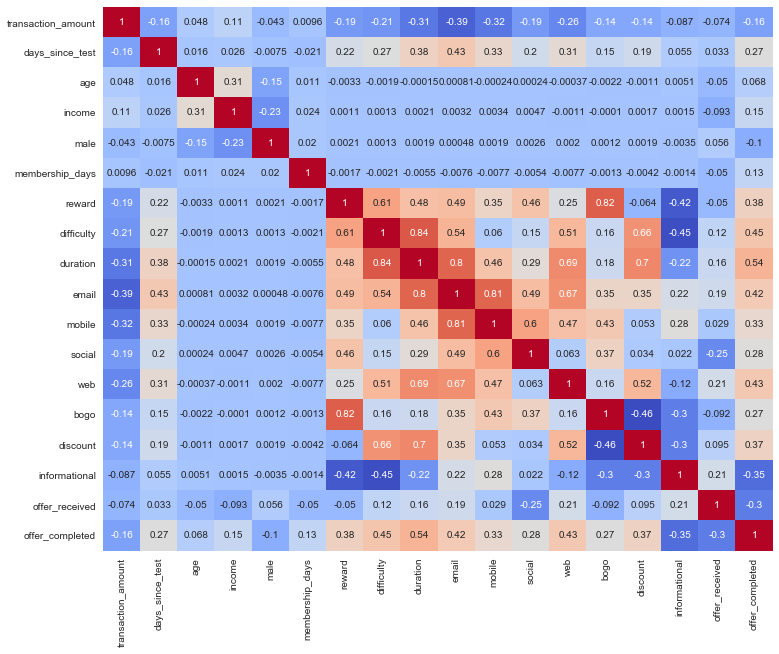

In [386]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),yticklabels=True,cbar=False,cmap='coolwarm', annot=True)

We can see some relatively highly correlated variables (> .75). However, let's leave them in the dataset for now.

**Feature Correlation on Dependend Variable Offer Completed**

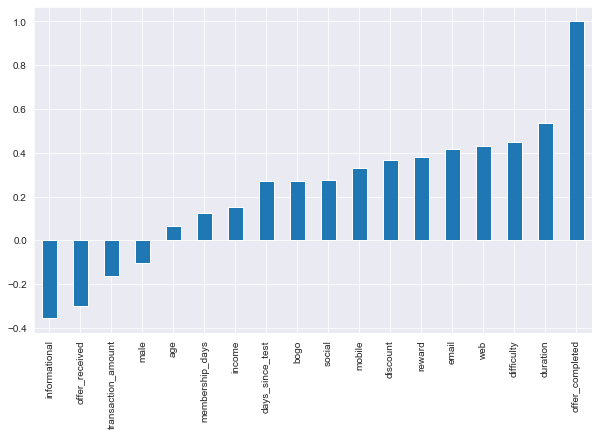

In [62]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
df.corr()["offer_completed"].sort_values().plot(kind="bar")

We ignore **Offer Completed** in the plot presented above since it goes without saying that it has 100% correlation with itself. It looks like **Duration**, **Difficulty**, **Web** and **Email** are positively correlated to the response variable. On the other hand, **Informational** and **Offer Received** have a negative correlation to the outcome which is not surprising.

**Create Training, Validation and Test Split**

In [39]:
# Split the data into training, validation and test datasets 
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=1)

In [40]:
X_train = df_train.drop(['offer_completed'], axis=1)
y_train = df_train.offer_completed.values
X_valid = df_valid.drop(['offer_completed'], axis=1)
y_valid = df_valid.offer_completed.values
X_test = df_test.drop(['offer_completed'], axis=1)
y_test = df_test.offer_completed

**Normalize Data**

In [41]:
# Since we have many different types of features in our dataset e.g. age, income etc. we should normalize the data

# create an instance of MinMaxScaler
scaler = MinMaxScaler().fit(X_train)

# now perform the transformations on the training, validation and test set
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [10]:
print("Training Data:", X_train.shape, y_train.shape,"\nValidation Data:", X_valid.shape, y_valid.shape,"\nTest Data:", X_test.shape, y_test.shape)

Training Data: (43993, 17) (43993,) 
Validation Data: (10999, 17) (10999,) 
Test Data: (13749, 17) (13749,)


# 4) Model Building and Validation

**Baseline Accuracy to Beat**

Let's take a naive approach as a baseline accuracy value to beat for all predictive models. Let's follow a "most frequent” approach. This approach looks at our response variable and always predicts the most frequent label. For our our response variable that would be:


In [11]:
print("Accuracy if we assume no customers complete an offer: {}%".format(round((df["offer_completed"]==0).sum() / len(df)*100,2)))

Accuracy if we assume no customers complete an offer: 59.98%


## Model 1: Random Forest

**Training the model**

In [12]:
# build RandomForestClassifier instance and fit on training data
rfc = RandomForestClassifier() # use default parameters first
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Validate the Model Accuracy**

In [13]:
# predict on the validation set
y_pred = rfc.predict(X_valid)
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred)*100))

Confusion Matrix
 [[5715  845]
 [ 509 3930]]

Validation Accuracy: 87.69%
 



87.69% accuracy is not too bad. We already beat the baseline accuracy goal by just taking the default model parameters and not addressing the slight **class imbalance** of roughly 40 : 60.

#### Random Forest: Addressing Class Imbalance and Tuning Model Parameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

In [22]:
# addressing class imbalance by setting an inverse weight ratio
class_weight = {0: sum(y_train==1) / len(y_train), 1: sum(y_train==0) / len(y_train)}
class_weight

{0: 0.4007948427643892, 1: 0.5992051572356109}

In [19]:
# Used this awesome link as reference:
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20
# Part%202.ipynbfrom sklearn.model_selection import GridSearchCV

# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
param_grid = {'bootstrap'        : [True],
              'max_depth'        : [10, 20, 30],
              'max_features'     : [15, 20, 25],
              'min_samples_leaf' : [2, 3, 5],
              'min_samples_split': [2, 8, 16],
              'n_estimators     ': [100, 200, 300]
             }

# Create the base model with class weight ratio
rf = RandomForestClassifier(random_state = 1, class_weight = class_weight)

# Create the grid search 
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs=-1, return_train_score=True)

In [20]:
# fit grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 15.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.3984270224808492,
                                                            1: 0.6015729775191507},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction...
                                              n_estimators=100, n_jobs=None,
                   

In [22]:
# get best parameters from grid search
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

**Validating Our Model Built with the Help of  Grid Search**

In [25]:
# define the best model parameters 
best_grid = grid_search.best_estimator_

# predict on validation data with best parameters
y_pred1 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred1)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred1)*100))

Confusion Matrix
 [[5615  945]
 [ 329 4110]]

Validation Accuracy: 88.42%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Use the Model to Predict Test Data**

In [26]:
# make predictions on test data  
y_pred2 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred2)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred2)*100))

# get classification report
print(classification_report(y_test, y_pred2))

Confusion Matrix
 [[6933 1270]
 [ 396 5150]]

Test Accuracy: 87.88%
 

              precision    recall  f1-score   support

           0       0.95      0.85      0.89      8203
           1       0.80      0.93      0.86      5546

    accuracy                           0.88     13749
   macro avg       0.87      0.89      0.88     13749
weighted avg       0.89      0.88      0.88     13749



The final test accuracy equals 87.88%.

## Model 2: Neural Network Classifier

**Training and Validating the Model**

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [27]:
# create the nn model
nn = keras.Sequential()
nn.add(Dense(units=17,activation="relu")) # 17 because 17 input features
nn.add(Dropout(0.5))
nn.add(Dense(units=8,activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=4,activation="relu"))
nn.add(Dropout(0.5))
# binary classification so we choose sigmoid activation function
nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [29]:
# fit the model on the training data 
history = nn.fit(X_train, y_train, epochs = 20, batch_size=32, validation_data=(X_valid, y_valid), workers = 5).history

Epoch 1/20
1375/1375 [==============================] - 1s 976us/step - loss: 0.5611 - accuracy: 0.6715 - val_loss: 0.3524 - val_accuracy: 0.8457
Epoch 2/20
1375/1375 [==============================] - 1s 988us/step - loss: 0.4648 - accuracy: 0.7315 - val_loss: 0.3199 - val_accuracy: 0.8494
Epoch 3/20
1375/1375 [==============================] - 1s 896us/step - loss: 0.4442 - accuracy: 0.7513 - val_loss: 0.3213 - val_accuracy: 0.8449
Epoch 4/20
1375/1375 [==============================] - 1s 941us/step - loss: 0.4348 - accuracy: 0.7576 - val_loss: 0.3018 - val_accuracy: 0.8652
Epoch 5/20
1375/1375 [==============================] - 1s 891us/step - loss: 0.4323 - accuracy: 0.7619 - val_loss: 0.3002 - val_accuracy: 0.8688
Epoch 6/20
1375/1375 [==============================] - 1s 868us/step - loss: 0.4320 - accuracy: 0.7600 - val_loss: 0.3184 - val_accuracy: 0.8695
Epoch 7/20
1375/1375 [==============================] - 1s 851us/step - loss: 0.4279 - accuracy: 0.7656 - val_loss: 0.3039 -

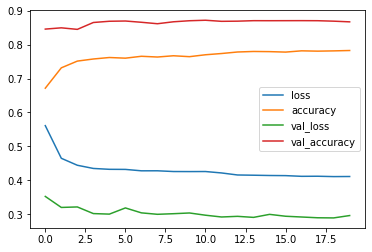

In [31]:
losses = pd.DataFrame(nn.history.history)
losses.plot()

The neural network classifier shows a validation accuracy of around 86.71% which is slightly worse than the initial RF model. However we simply used the default parameters thus far. Let's try to improve the accuracy.

#### Neural Network Classifier: Tuning Model Parameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [33]:
# create the nn model
def build_model(lr=0.01):
    '''
    This function builds a neural network classifier.
    '''
    nn = Sequential()
    nn.add(Dense(units=17,activation="relu")) # 17 because 17 input features
    nn.add(Dropout(0.5))
    nn.add(Dense(units=8,activation="relu"))
    nn.add(Dropout(0.5))
    nn.add(Dense(units=4,activation="relu"))
    nn.add(Dropout(0.5))
    # binary classification so we choose sigmoid activation function
    nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
    # set optimizer
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return nn

In [34]:
# Create the actual model
model = KerasClassifier(build_fn=build_model, batch_size=16, epochs=10)

In [35]:
# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
batch_size = [16, 64, 128, 144]
epochs = [10, 50, 100, 200]
learn_rate = [0.0001, 0.001, 0.01, 0.1]

# create the parameter grid
param_grid = dict(lr=learn_rate, batch_size=batch_size,epochs=epochs)

# build the grid search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, verbose = 2, n_jobs=-1, return_train_score=True)

In [36]:
# fit grid search on the training data
grid_results = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 46.5min finished


Epoch 1/200
2750/2750 [==============================] - 2s 631us/step - loss: 0.5063 - accuracy: 0.6922
Epoch 2/200
2750/2750 [==============================] - 2s 637us/step - loss: 0.4029 - accuracy: 0.7744
Epoch 3/200
2750/2750 [==============================] - 2s 632us/step - loss: 0.3937 - accuracy: 0.7769
Epoch 4/200
2750/2750 [==============================] - 2s 637us/step - loss: 0.3915 - accuracy: 0.7787
Epoch 5/200
2750/2750 [==============================] - 2s 631us/step - loss: 0.3921 - accuracy: 0.7776
Epoch 6/200
2750/2750 [==============================] - 2s 643us/step - loss: 0.3909 - accuracy: 0.7784
Epoch 7/200
2750/2750 [==============================] - 2s 648us/step - loss: 0.3898 - accuracy: 0.7805
Epoch 8/200
2750/2750 [==============================] - 2s 634us/step - loss: 0.3885 - accuracy: 0.7818
Epoch 9/200
2750/2750 [==============================] - 2s 733us/step - loss: 0.3879 - accuracy: 0.7794
Epoch 10/200
2750/2750 [==============================]

2750/2750 [==============================] - 2s 751us/step - loss: 0.3823 - accuracy: 0.7840
Epoch 155/200
2750/2750 [==============================] - 2s 734us/step - loss: 0.3841 - accuracy: 0.7853
Epoch 156/200
2750/2750 [==============================] - 2s 725us/step - loss: 0.3830 - accuracy: 0.7869
Epoch 157/200
2750/2750 [==============================] - 2s 698us/step - loss: 0.3799 - accuracy: 0.7884
Epoch 158/200
2750/2750 [==============================] - 2s 705us/step - loss: 0.3816 - accuracy: 0.7879
Epoch 159/200
2750/2750 [==============================] - 2s 705us/step - loss: 0.3812 - accuracy: 0.7878
Epoch 160/200
2750/2750 [==============================] - 2s 709us/step - loss: 0.3830 - accuracy: 0.7861
Epoch 161/200
2750/2750 [==============================] - 2s 714us/step - loss: 0.3819 - accuracy: 0.7851
Epoch 162/200
2750/2750 [==============================] - 2s 695us/step - loss: 0.3821 - accuracy: 0.7838
Epoch 163/200
2750/2750 [==========================

In [37]:
# get best parameters from grid search
grid_results.best_params_

{'batch_size': 16, 'epochs': 200, 'lr': 0.001}

**Validating Our Model Built with the Help of  Grid Search**

In [42]:
# define the best model parameters 
best_grid = grid_results.best_estimator_

# predict on validation data with best parameters
y_pred3 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred3)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred3)*100))

Confusion Matrix
 [[5262 1298]
 [ 131 4308]]

Validation Accuracy: 87.01%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Use the Model to Predict Test Data**

In [43]:
# make predictions on test data  
y_pred4 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred4)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred4)*100))

# get classification report
print(classification_report(y_test, y_pred4))

Confusion Matrix
 [[6468 1735]
 [ 150 5396]]

Test Accuracy: 86.29%
 

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      8203
           1       0.76      0.97      0.85      5546

    accuracy                           0.86     13749
   macro avg       0.87      0.88      0.86     13749
weighted avg       0.89      0.86      0.86     13749



## Model 3: XGBoost
<br>

XGBoost or eXtreme Gradient Boosting is an advanced implementation of the gradient boosting algorithm.
XGBoost is a great choice here because the dataset is quite large with initially 68,741 observations. This is because it is very computationally efficient and typically yields very high accuracy.

**Training The Model**

In [54]:
# set up the classifier. Once again we will use the default parameters as starting point
xgbc = XGBClassifier()

# fit the model on the training set
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Validating the Model's Performance**

In [55]:
# predict validation data
y_pred5 = xgbc.predict(X_valid)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred5)))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_valid, y_pred5)*100))

Confusion Matrix
 [[5809  751]
 [ 453 3986]]
Validation Accuracy: 89.05%


As expected, even with default parameters XGBoost yields very high predictive accuracy. In fact, it already shows the highest accuracy among the 3 predictive models without parameter tuning.

#### XGBoost Classifier: Tuning Model Parameters with Grid Search

Here we will tune some of the hyperparameters to boost the model's performance. It won't find the optimal solution, but a solution that is sufficient considering the limited resources available.

**Training The Model**

In [31]:
# define the model
xgbc = XGBClassifier()

# defining parameter grid for XGBoost
parameters = {"learning_rate"        : [0.01, 0.10, 0.20],
              "max_depth"            : [8, 9, 10],
              "min_child_weight"     : [1, 2],
               # gamma: min loss reduction required to make a further partition on a leaf node. The larger the more conservative
              "gamma"                : [0.0, 0.2 , 0.4, 0.6],
              "colsample_bytree"     : [0.5, 0.6, 0.8, 1.0],
              "subsample"            : [0.7, 0.8, 0.9, 1.0], # subsample ratio of the training instances, prevents overfitting
              "n_estimators"         : [100, 150]
             }

# setting up the grid search
grid_search = GridSearchCV(estimator = xgbc, param_grid = parameters, cv = 3, n_jobs=-1, verbose=2)

In [32]:
# fit grid search on the training data
grid_results = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 66.4min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 85.6min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 109.5min
[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed: 111.6min finished


In [33]:
# get best parameters from grid search
grid_results.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.9}

**Validating Our Model Built with the Help of  Grid Search**

In [34]:
# define the best model parameters 
best_grid = grid_results.best_estimator_

# predict on validation data with best parameters
y_pred8 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred8)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred8)*100))

Confusion Matrix
 [[5776  784]
 [ 395 4044]]

Validation Accuracy: 89.28%
 



**Use the Model to Predict Test Data**

In [35]:
# let's use the trained XBG model to predict the test data 
y_pred9 = best_grid.predict(X_test)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred9)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred9)*100))

# get classification report
print(classification_report(y_test, y_pred9))

Confusion Matrix
 [[7125 1078]
 [ 483 5063]]

Test Accuracy: 88.65%
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      8203
           1       0.82      0.91      0.87      5546

    accuracy                           0.89     13749
   macro avg       0.88      0.89      0.88     13749
weighted avg       0.89      0.89      0.89     13749



## Model Comparison

In [83]:
print("Random Forest\nValidation Accuracy:{}% \nTest Accuracy: {}%".format(88.42, 87.88))
print("\nNeural Network\nValidation Accuracy: {}%\nTest Accuracy: {}%".format(87.01, 86.29))
print("\nXGBoost\nValidation Accuracy: {}%\nTest Accuracy: {}%\n".format(89.28, 88.65))

Random Forest
Validation Accuracy:88.42% 
Test Accuracy: 87.88%

Neural Network
Validation Accuracy: 87.01%
Test Accuracy: 86.29%

XGBoost
Validation Accuracy: 89.28%
Test Accuracy: 88.65%



# 5) Saving the Model

In [86]:
# Save to file to working directory
joblib_file = "joblib_final_model.pkl"
joblib.dump(best_grid, joblib_file)

C:\Users\joell\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



['joblib_final_model.pkl']

In [57]:
# Load from file
final_model = joblib.load("joblib_final_model.pkl")

In [60]:
# Calculate the accuracy and predictions
score = final_model.score(X_test, y_test)
print("Test Accuracy: {0:.2f} %".format(100 * score))

Test Accuracy: 88.65 %


# 6) Conclusion

**Demographics**
- Most customers are roughly aged between 40 and 75 years with an average age of around 54 years
- 41.9% female and 58.1% male customers 
- Average customer income equals 65,388.01 US dollars
- Only 40.02% of customers did complete an offer in the past
- Average income of customers who did complete an offer in the past: 69,398.28 US dollars (vs. 62,711.8 US dollars of those who did not)
- Average age of customers who did complete an offer in the past: 55.8 years (vs. 53.37 years of those who did not)
- The proportion of female customers who completed an offer is higher than male customers (46.04% vs. 35.69%)


Based on these findings, women tend to react more positively towards the promotions than men. Despite the fact that women only make up around 40% of the customers in the dataset provided, they almost contribute the same number of **completed offers** than men. (13,260 women vs. 14.254 men).

**Offers**
- Customers who received **Discount**: 31.74%
- Customers who received **BOGO**: 31.65%
- Customers who didn't receive an offer: 20.79%
- Customers who received **Informational**: 15.82%

- The offer type with the highest success rate is **Discount** (66.58%), followed by **BOGO** (59.69%)
- **Informational** offers can not be traced to any sales

Generally, **discounts** show the highest success rate among the 3 offer types and are also the most frequent promotion sent to customers. Furthermore, out of all offers sent out to customers, **informational** promotions make up approx. 15% of offers. 20.79% of customers did not receive any promotion. 

In terms of difficulty and duration, one can infer that a difficulty level of 10 USD leads to the most completed offers, followed by a level of 5 USD. Further, most offers were completed for promotions that were only valid for 7 days, followed by 10 days and 5 days respectively. No offers were completed for offers that are only valid for 3 or 4 days.

**Contact Methods**

When comparing the 4 contact methods used (email, mobile, social, web), most customers were contacted via email and mobile device. However, both of these contact methods showed a lower success rate of customers completing an offer compared to social media and web. 

- Customers contacted via email: 79.21%
- Customers contacted via mobile device: 71.2%
- Customers contacted via web: 63.33%
- Customers contacted via social media: 47.48%


- Web success rate: 56.09%
- Social media success rate: 54.31%
- Email success rate: 50.53%
- Mobile success rate: 50.3%

**Predictive Model**

We built and tuned 3 classifiaction prediction models with the goal to accurately predict our target customers. Our target customer sare defined as customers who have a high likelihood of completing an offer. The 3 models are Random Forest, Neural Network and eXtreme Gradient Boosting (XGBoost). After training and validating the model performance the following results were geneated:

- The Random Forest Classifier showed a predictive accuracy of 87.88%
- The Neural Network Classifier showed a predictive accuracy of 86.29%
- The **XBGoost** Classifier showed a predictive accuracy of **88.65%** 

Based on these results, we selected XGBoost as the final classifiaction prediction model with which we managed to predict our target customers with approximately 88.65% accuracy.

### Recommendations

In order to increase the company's marketing strategy effectiveness, we derived the following 3 recommendations based on the analysis findings above.

**1) Predicting Target Customers**
- Identify target customers using the XGBoost model

**2) Choosing the right Contact Method(s)**

Increase the usage of the following communication channel(s) to send offers:
- Web (because it showed the highest success rate among the 4 contact methods)
- Social media (because it showed the second highest success rate among the 4 contact methods)

**3) Customizing the Offer Appropriately**
- Send out more discounts beacuse they show the highest success rate
- Keep the amount of BOGO the same beacuse they still show a decent success rate
- Tailor the period an offer is valid around 7 - 10 days because this period showed the highest completed offers
- Avoid making offers valid for only 3 - 4 days because these offers didn't result in any completed offers

The goal is to decrease the total number of customers who did not receive an offer (20.79%) and to increase the success rate of offers sent out (currently 40.02%). This can be done by increasingly targeting female customers who match the target customer profile of customers with slightly above average income (69,398.28 US dollars) and age (55.8 years).

Following these recommendations will ensure a more efficient allocation of resources, an increase in the marketing success rate and ultimately growth in profitability for the organization.